# (will be) spending most my life livin' in the pytorch paradise

## set up data

In [1]:
%matplotlib inline
from fastai.basics import *

In [2]:
path = Config().data_path()/'mnist'
path.ls()

[PosixPath('/home/jupyter/.fastai/data/mnist/mnist_png.tgz'),
 PosixPath('/home/jupyter/.fastai/data/mnist/mnist.pkl.gz'),
 PosixPath('/home/jupyter/.fastai/data/mnist/mnist_png')]

In [3]:
with gzip.open(path/'mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

(50000, 784)

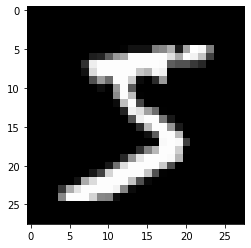

In [4]:
plt.imshow(x_train[0].reshape((28,28)), cmap='gray')
x_train.shape

In [5]:
x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))
n,c = x_train.shape
x_train.shape, y_train.min(), y_train.max()

(torch.Size([50000, 784]), tensor(0), tensor(9))

In [6]:
# bs = 64
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds)
data.c = 10
data.classes = ['0','1','2','3','4','5','6','7','8','9']

In [7]:
x,y = next(iter(data.train_dl))
x.shape, y.shape

(torch.Size([64, 784]), torch.Size([64]))

In [8]:
loss_func = nn.CrossEntropyLoss()

In [9]:
def update(x,y,lr, model, epoch_num, verbose=False):
    if verbose:
        print(f'epoch={epoch_num}')
    opt = optim.Adam(model.parameters(),lr) #torch.optim
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

## create fully connected model

In [31]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super(Mnist_NN, self).__init__()
        self.lin1 = nn.Linear(784, 50, bias=True)
        self.lin2 = nn.Linear(50, 10, bias=True)
        
    def forward(self, x): 
        x = F.relu(self.lin1(x))
        return self.lin2(x)

In [32]:
model = Mnist_NN().cuda()

In [33]:
model,model.lin1,model.lin2,model(x).shape

(Mnist_NN(
   (lin1): Linear(in_features=784, out_features=50, bias=True)
   (lin2): Linear(in_features=50, out_features=10, bias=True)
 ),
 Linear(in_features=784, out_features=50, bias=True),
 Linear(in_features=50, out_features=10, bias=True),
 torch.Size([64, 10]))

In [34]:
[p.shape for p in model.parameters()]

[torch.Size([50, 784]),
 torch.Size([50]),
 torch.Size([10, 50]),
 torch.Size([10])]

# train a bit

In [36]:
fully_connected_losses = [update(x,y,1e-3, model, 0) for x,y in data.train_dl]

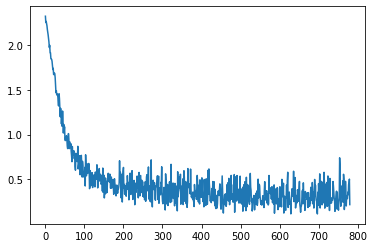

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fbe1f9a84d0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/opt/conda/lib/python3.7/multiprocessing/popen_fork.py", line 48, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/opt/conda/lib/python3.7/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


In [37]:
plt.plot(fully_connected_losses)

In [38]:
learn = Learner(data, Mnist_NN(), loss_func=loss_func, metrics=accuracy)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


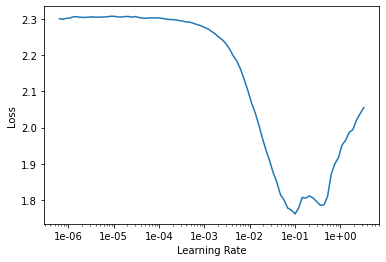

In [39]:
learn.lr_find()
learn.recorder.plot()

# train for real

In [40]:
learn.fit_one_cycle(2,1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.192465,0.148124,0.954600,00:03
1,0.095807,0.106780,0.969000,00:03


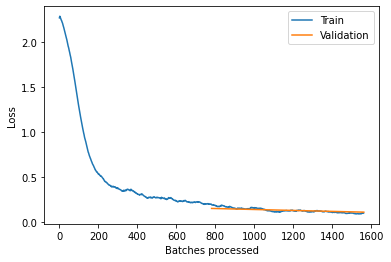

In [41]:
learn.recorder.plot_losses()

# create a cnn model

In [10]:
from torch import nn

In [11]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super(Mnist_CNN, self).__init__()
        self.layers = nn.Sequential(
            Lambda(lambda x: x.view(-1, 1, 28, 28)),
            nn.Conv2d(1, 10, stride=1, kernel_size=5), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(10, 50, stride=1, kernel_size=5), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(80*10,10, bias=True))
        
    def forward(self, x):
        return self.layers(x)

In [12]:
cnn_model = Mnist_CNN().cuda()

In [13]:
[p.shape for p in cnn_model.parameters()], cnn_model, cnn_model(x).shape

([torch.Size([10, 1, 5, 5]),
  torch.Size([10]),
  torch.Size([50, 10, 5, 5]),
  torch.Size([50]),
  torch.Size([10, 800]),
  torch.Size([10])],
 Mnist_CNN(
   (layers): Sequential(
     (0): Lambda()
     (1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
     (2): ReLU()
     (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (4): Conv2d(10, 50, kernel_size=(5, 5), stride=(1, 1))
     (5): ReLU()
     (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (7): Flatten()
     (8): Linear(in_features=800, out_features=10, bias=True)
   )
 ),
 torch.Size([64, 10]))

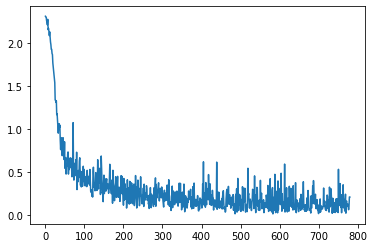

In [14]:
losses = [update(x,y,1e-3, cnn_model, epoch_num) for epoch_num, (x,y) in enumerate(data.train_dl)]
plt.plot(losses)

In [18]:
cnn_learn = Learner(data, Mnist_CNN(), loss_func=loss_func, metrics=accuracy)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


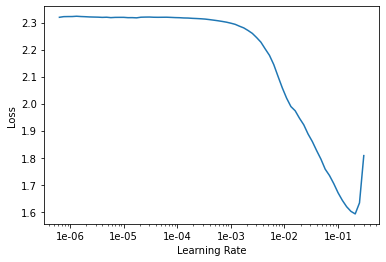

In [19]:
cnn_learn.lr_find()
cnn_learn.recorder.plot()

In [20]:
cnn_learn.save('mnist-torch-cnn-stage-1')

In [21]:
cnn_learn.load('mnist-torch-cnn-stage-1')

Learner(data=DataBunch;

Train: <torch.utils.data.dataset.TensorDataset object at 0x7fbe15403cd0>;

Valid: <torch.utils.data.dataset.TensorDataset object at 0x7fbe154038d0>;

Test: None, model=Mnist_CNN(
  (layers): Sequential(
    (0): Lambda()
    (1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(10, 50, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Flatten()
    (8): Linear(in_features=800, out_features=10, bias=True)
  )
), opt_func=functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)), loss_func=CrossEntropyLoss(), metrics=[<function accuracy at 0x7fbe777c0560>], true_wd=True, bn_wd=True, wd=0.01, train_bn=True, path=PosixPath('.'), model_dir='models', callback_fns=[functools.partial(<class 'fastai.basic_train.Recorder'>, add_time=True, silent=False)]

In [22]:
cnn_learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.117925,0.099085,0.971100,00:04
1,0.077632,0.071015,0.978100,00:04
2,0.042130,0.048872,0.987000,00:04
3,0.018672,0.035477,0.990900,00:04
4,0.008395,0.039354,0.990800,00:04


In [23]:
cnn_learn.save('mnist-torch-cnn-stage-2')

In [25]:
cnn_learn.load('mnist-torch-cnn-stage-2');

In [26]:
interp = ClassificationInterpretation.from_learner(cnn_learn)
losses,idxs = interp.top_losses()

In [ ]:
interp.plot_confusion_matrix()